<h2><center><font color='Green'>Kriging 

<h3><center><font color='Green'> Submitted by: Arefin Siddikui(L20554425)

<h5> Import Necessary libraries

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_map_utils as mapu # for North Arrow
from matplotlib_scalebar.scalebar import ScaleBar # to draw scalebar
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid

<h5> Set Path and Read files

In [3]:
# Set the working directory
path = r"C:/Users/asidd/Downloads/Final Project/Kriging"
os.chdir(path)


In [6]:
# Import files
fname = 'Field_Data.csv'
a = pd.read_csv(fname)

<h5> Create a Point Geodataframe from CSV file

In [8]:
# Create a point object a geometry column from the longitude and latitude columns
jeffas = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(a.X, a.Y))

# Set the coordinate reference system (CRS) if you know it
jeffas.crs = 'EPSG:26915'  

jeffas.head()


,Img_Label,X,Y,Z,Hor_Accuracy,Ver_Accuracy,Remarks,geometry
0,A,396103.8633,3323564.158,4.425630,0.10,0.10,Concrete Top Left,POINT (396103.863 3323564.158)
1,B,396136.7596,3323564.703,4.492191,0.10,0.10,Concrete Top Right,POINT (396136.76 3323564.703)
2,C,396136.4109,3323541.640,5.300878,0.23,0.22,Concrete Bottom Right,POINT (396136.411 3323541.64)
3,D,396103.5592,3323540.882,4.571488,0.13,0.15,Concrete Bottom Left,POINT (396103.559 3323540.882)
4,F1,396123.5924,3323552.059,4.698696,0.10,0.10,Field Point 1,POINT (396123.592 3323552.059)


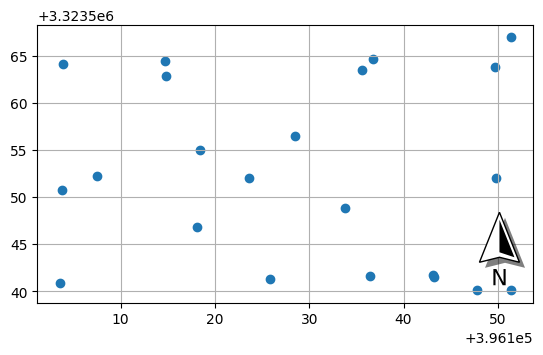

In [17]:
fig,ax = plt.subplots()
jeffas.plot(ax=ax)
plt.grid()
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.show()

<h5> Obtain X and Y coordinates in NAD83 Datum along with As Values

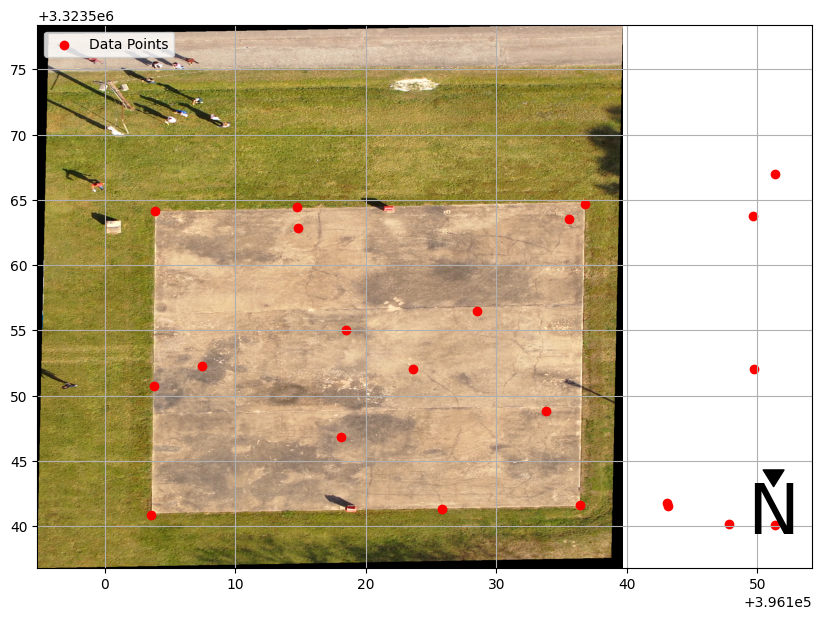

In [16]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# Set the working directory and file paths
path = r"C:/Users/asidd/Downloads/Final Project/Kriging"
os.chdir(path)
image_path = r"C:/Users/asidd/Downloads/Final Project/Kriging/field_image_modified.tif"
fname = "Field_Data.csv"

# Read the CSV file and create GeoDataFrame
a = pd.read_csv(fname)
jeffas = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(a.X, a.Y))
jeffas.crs = "EPSG:26915"

# Function to add a custom north arrow
def add_north_arrow(ax, size=50):
    x, y, arrow_length = 0.95, 0.1, 0.05
    ax.annotate('N', xy=(x, y + arrow_length), xytext=(x, y),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=size, xycoords=ax.transAxes)

# Plot the georeferenced image with the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Open the georeferenced image
with rasterio.open(image_path) as src:
    show(src, ax=ax)  # Plot the image as a base layer

# Plot GeoDataFrame on top of the image
jeffas.plot(ax=ax, color='red', marker='o', label="Data Points")

# Add grid, north arrow, and legend
plt.grid()
add_north_arrow(ax)
ax.legend(loc="upper left")

plt.show()


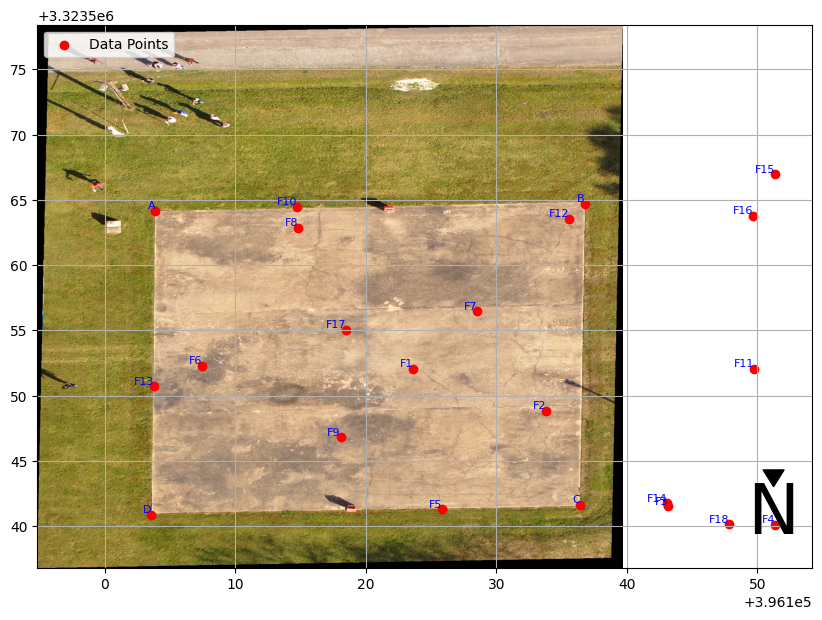

In [18]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# Set the working directory and file paths
path = r"C:/Users/asidd/Downloads/Final Project/Kriging"
os.chdir(path)
image_path = r"C:/Users/asidd/Downloads/Final Project/Kriging/field_image_modified.tif"
fname = "Field_Data.csv"

# Read the CSV file and create GeoDataFrame
a = pd.read_csv(fname)
jeffas = gpd.GeoDataFrame(a, geometry=gpd.points_from_xy(a.X, a.Y))
jeffas.crs = "EPSG:26915"

# Function to add a custom north arrow
def add_north_arrow(ax, size=50):
    x, y, arrow_length = 0.95, 0.1, 0.05
    ax.annotate('N', xy=(x, y + arrow_length), xytext=(x, y),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=size, xycoords=ax.transAxes)

# Plot the georeferenced image with the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Open the georeferenced image
with rasterio.open(image_path) as src:
    show(src, ax=ax)  # Plot the image as a base layer

# Plot GeoDataFrame on top of the image
jeffas.plot(ax=ax, color='red', marker='o', label="Data Points")

# Add point labels
for x, y, label in zip(jeffas.geometry.x, jeffas.geometry.y, jeffas['Img_Label']):
    ax.text(x, y, label, fontsize=8, color='blue', ha='right', va='bottom')

# Add grid, north arrow, and legend
plt.grid()
add_north_arrow(ax)
ax.legend(loc="upper left")

plt.show()


In [20]:
# Obtain lat, Lon and z values for Z from Jeffasutm
x = list(jeffas.geometry.x)
y = list(jeffas.geometry.y)
z = list(jeffas.Z)

<h5> Obtain Bounds to Create a Grid to Interpolate (extrapolate)

In [23]:
# Get the bounds of datasets to create a grid of size delta
delta = 2 # create 2 m x 2 m grid
xmin, ymin, xmax, ymax = jeffas.total_bounds
print(xmin, ymin, xmax,ymax)
gridx = np.arange(xmin,(xmax+delta),delta)
gridy = np.arange(ymin,(ymax+delta),delta)

396103.5592 3323540.109 396151.3764 3323566.964


<h5> Perform Ordinary Kriging to Identify Best Variogram Model with Actual Data

The model that provides the best overall prediction of As as compared to measured data will be used here.  Ideally we would like to split the data into training and testing data and train the model with training data and test with the independent dataset.  Otherwise you could also use cross-validation.  However, here we simply use training error for simplicity.  

In [27]:
# Perform ordinary Kriging and select the best variogram
# The best variogram gives minimum root mean sq. error
models = ['linear', 'power', 'gaussian', 'exponential', 'spherical']
varioerr = []
for m in models:
    ok = OrdinaryKriging(x, y, z, variogram_model=m, verbose=False, enable_plotting=False)
    Aspred,ss = ok.execute("grid", x, y)
    err = np.nansum((z-Aspred)**2)
    rmse = np.sqrt(err/len(z))
    varioerr.append(rmse)

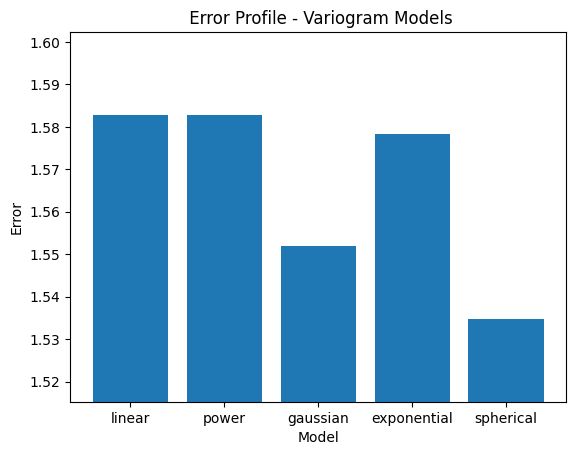

In [29]:
# Make a bar plot of errors
minlim = np.min(varioerr) - np.std(varioerr)
maxlim = np.max(varioerr) + np.std(varioerr)
plt.bar(models,varioerr)
plt.ylim(minlim,maxlim)
plt.ylabel('Error')
plt.xlabel('Model')
plt.title(' Error Profile - Variogram Models')
plt.show()

The best fit model is the Spherical Model.  But you can see any of the other models also perform closely.  (Notice the values of the Y-axis).  

<h5>  Perform Ordinary Kriging with the best fit Spherical Model on a grid

In [33]:
# Step 3: Perform ordinary kriging with Spherical Model (best fit model)
ok = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',  # Automatically fits a spherical model
    verbose=True,
    enable_plotting=False
)

# Make predictions on the grid
z_pred, ss_pred = ok.execute('grid', gridx, gridy)

# Step 4: Extract variogram information
lags = ok.lags  # Distance bins
semivariance = ok.semivariance  # Computed semivariance values

# Step 5: Compute theoretical variogram values
# Extract model parameters
model_parameters = ok.variogram_model_parameters
sill = model_parameters[0]
range_ = model_parameters[1]
nugget = model_parameters[2]

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.04978331385683893
Full Sill: 0.12042053827424126
Range: 0.8549420916262509
Nugget: 0.07063722441740233 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



<h5> Write a function for theoretial semi-variogram and Plot the empirical and theoretical variogram clouds

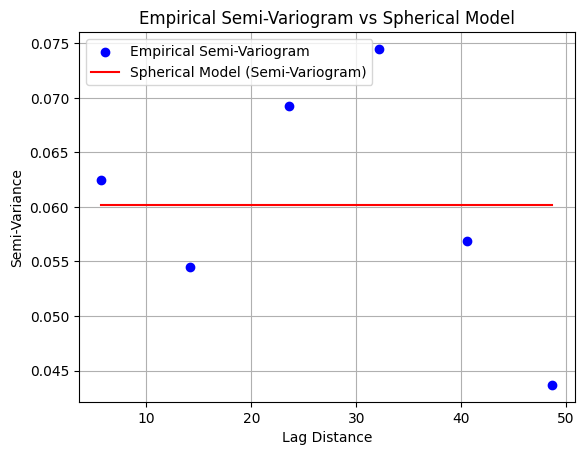

In [36]:
# Define the spherical variogram model (unchanged)
def spherical_variogram(h, sill, range_, nugget):
    h = np.array(h)
    gamma = np.zeros_like(h)
    mask = h <= range_
    gamma[mask] = nugget + sill * (1.5 * (h[mask] / range_) - 0.5 * (h[mask] / range_) ** 3)
    gamma[~mask] = nugget + sill
    return gamma

# Assuming lags, sill, range_, nugget, and ok (Ordinary Kriging) are defined earlier
theoretical_variogram = spherical_variogram(lags, sill, range_, nugget)

# Extract variogram information for plotting
lags = ok.lags  # Distance bins
semivariance = ok.semivariance  # Computed semivariance values

# Convert the variogram to semi-variogram (divide by 2)
semi_variance = semivariance / 2  # Semi-variogram is half of the variogram

# Plot the empirical semi-variogram and theoretical model
plt.figure()
plt.scatter(lags, semi_variance, color='blue', label='Empirical Semi-Variogram')
plt.plot(lags, theoretical_variogram / 2, color='red', label='Spherical Model (Semi-Variogram)')
plt.xlabel('Lag Distance')
plt.ylabel('Semi-Variance')
plt.title('Empirical Semi-Variogram vs Spherical Model')
plt.grid()
plt.legend()
plt.show()

<h5> Plot the Predicted Surface on a grid

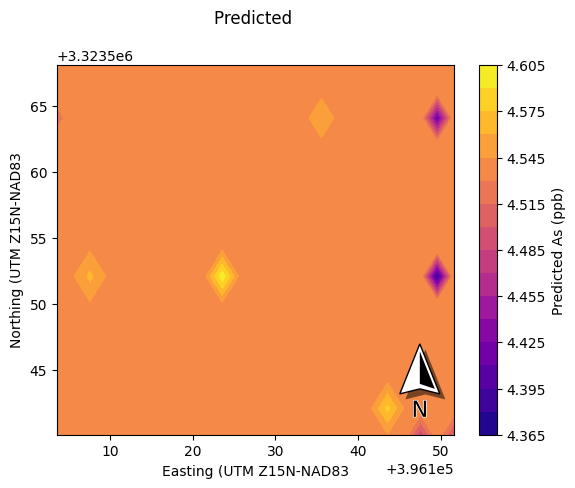

In [46]:
# Step 5: Plot the predicted surface
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, z_pred, levels=20, cmap='plasma')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
plt.colorbar(contour, label='Predicted As (ppb)')
plt.title('Predicted ',pad=30)
plt.xlabel('Easting (UTM Z15N-NAD83')
plt.ylabel('Northing (UTM Z15N-NAD83')
plt.show()


<h5> Plot the Prediction Standard Error

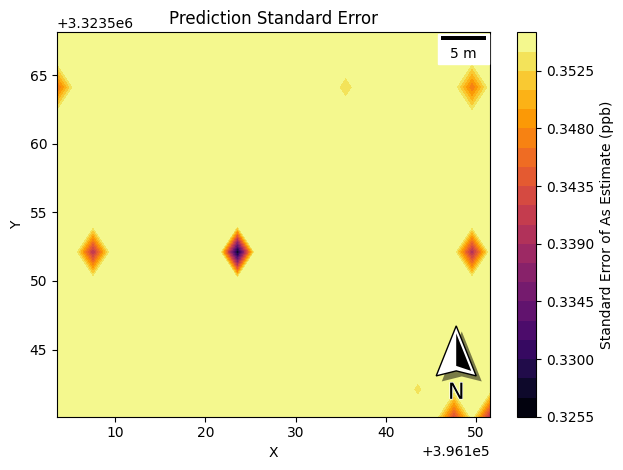

In [42]:
# Step 6: Plot the prediction standard error
fig, ax = plt.subplots()
contour = ax.contourf(gridx, gridy, np.sqrt(ss_pred), levels=20, cmap='inferno')
mapu.north_arrow.north_arrow(ax=ax, location="lower right", rotation={"degrees":0})
scalebar = ScaleBar(0.001, "km")  
ax.add_artist(scalebar)
plt.colorbar(contour, label='Standard Error of As Estimate (ppb)')
plt.title('Prediction Standard Error')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

The model does near the data points but exhibits higher error when there is no data (yellow regions) A few data points near the south-east quadrant will improve predictions.